# Background checkup.

The basic idea behind analysing the Goodreads dataset is to get a fair idea about the relationships between the multiple attributes a book might have, such as:the aggregrate rating of each book, the trend of the authors over the years and books with numerous languages. With over a hundred thousand ratings, there are books which just tend to become popular as each day seems to pass. 

We've always conisdered the magical persona books seem to hold, and with this notebook, we step out on a journey to see what kind of books really drives people to read in this era of modern smart devices. 

With such a vast, overwhelming number of factors, we'll go over such demographics: 
- Does any relationship lie between ratings and the total ratings given?
- Where do majority of the books lie, in terms of ratings - Does reading a book really bring forth bias for the ratings?
- Do authors tend to perform same over time, with all their newer books? Or do they just fizzle out. 
- Do number of pages make an impact on reading styles, ratings and popularity?
- Can books be recommended based on ratings? Is that a factor which can work?



### If you like my work, please consider upvoting my kernel. :)

# What's in this kernel?


1. [Loading required libraries, with installation](#1)

2. [Getting basic ideas about the data](#2)

3. [Exploratory Data Analysis](#3)
    1. [Which are the books with most occurances in the list?](#4)
    2. [What is the distribution of books across languages?](#5)
    3. [Which are the top 10 most rated books?](#6)
    4. [Which are the authors with most books?](#7)
    5. [Performance of an author over time:](#8)
        
        1. [Stephen King](#9)
        
        2. [Agatha Christie](#10)
        
        3. [Dan Brown](#11)
        
        4. [J.K. Rowling](#12)
        
    6. [Which are the top 10 highly rated authors?](#13)
    7. [What is the rating distribution for the books?](#14)
    8. [Is there relationship between ratings and review counts?](#15)
    9. [Is there a relationship between number of pages and ratings?](#16)
    10. [Is there a relationship between ratings and ratings count?](#17)
    11. [Which are the books with the highest reviews?](#18)
    
    
4. [Topic Modelling](#19)
    1. [KMeans Clustering with outliers](#20)
    2. [KMeans Clustering with optimisaztion](#21)


5. [Book Recommendation Engine](#22)
    

> # Loading libraries with installation<a id="1"></a> <br>

In [1]:
!pip install isbnlib
!pip install newspaper3k
!pip install goodreads_api_client

     |████████████████████████████████| 81kB 3.1MB/s 
     |████████████████████████████████| 215kB 2.8MB/s 
     |████████████████████████████████| 194kB 40.9MB/s 
     |████████████████████████████████| 7.4MB 43.2MB/s 
     |████████████████████████████████| 51kB 24.2MB/s 
  Created wheel for feedparser: filename=feedparser-5.2.1-cp36-none-any.whl size=44940 sha256=026e413b701a155ddc01a71d0d73bba11ebb04c4fb6ea06338abbe21ad6c4c4a
  Stored in directory: /tmp/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
  Created wheel for jieba3k: filename=jieba3k-0.35.1-cp36-none-any.whl size=7398406 sha256=f1b9c37cbdd5ed6d0abc50bd42f6d15d1046aaead19710c717ec5a47eb48f50f
  Stored in directory: /tmp/.cache/pip/wheels/83/15/9c/a3f1f67e7f7181170ad37d32e503c35da20627c013f438ed34
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-cp36-none-any.whl size=3358 sha256=89a0535c2b2e93230469e8c8fa9df7ffb6e5d02321b721307bf57947985a8ba6
  Stored in directory: /tmp/.cache/pi

In [2]:

import numpy as np 
import pandas as pd
import os
import seaborn as sns
import isbnlib
from newspaper import Article
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from tqdm import tqdm
from progressbar import ProgressBar
import re
from scipy.cluster.vq import kmeans, vq
from pylab import plot, show
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import goodreads_api_client as gr
from sklearn.cluster import KMeans
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


In [3]:
import warnings
warnings.filterwarnings("ignore")

> # Getting Basic Ideas<a id="2"></a> <br>

In [4]:
df = pd.read_csv('../input/books.csv', error_bad_lines = False)



b'Skipping line 4012: expected 10 fields, saw 11\nSkipping line 5688: expected 10 fields, saw 11\nSkipping line 7056: expected 10 fields, saw 11\nSkipping line 10601: expected 10 fields, saw 11\nSkipping line 10668: expected 10 fields, saw 11\n'


In [5]:
df.index = df['bookID']

In [6]:
#Finding Number of rows and columns
print("Dataset contains {} rows and {} columns".format(df.shape[0], df.shape[1]))


Dataset contains 13714 rows and 10 columns


Let's begin the journey, there seems to be J.K. Rowling, predominantly in the head of this dataframe. Yet, as we've all come to know and love her, there's Mary here too. Let's fix this, just for the sake of brevity with all the numerous listings her books are sure to have. 

In [7]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling-Mary GrandPré,4.56,0439785960,9780439785969,eng,652,1944099,26249
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling-Mary GrandPré,4.49,0439358078,9780439358071,eng,870,1996446,27613
3,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling-Mary GrandPré,4.47,0439554934,9780439554930,eng,320,5629932,70390
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling-Mary GrandPré,4.55,043965548X,9780439655484,eng,435,2149872,33964


Fixing the name for every Harry Potter series to be just J.K. Rowling, the database is nearly ready for EDA

In [8]:
df.replace(to_replace='J.K. Rowling-Mary GrandPré', value = 'J.K. Rowling', inplace=True)



In [9]:
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,# num_pages,ratings_count,text_reviews_count
bookID,,,,,,,,,,
1,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling,4.56,0439785960,9780439785969,eng,652,1944099,26249
2,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling,4.49,0439358078,9780439358071,eng,870,1996446,27613
3,3,Harry Potter and the Sorcerer's Stone (Harry P...,J.K. Rowling,4.47,0439554934,9780439554930,eng,320,5629932,70390
4,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.41,0439554896,9780439554893,eng,352,6267,272
5,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling,4.55,043965548X,9780439655484,eng,435,2149872,33964


#### Columns Description: 

- **bookID** Contains the unique ID for each book/series
- **title** contains the titles of the books
- **authors** contains the author of the particular book
- **average_rating** the average rating of the books, as decided by the users
- **ISBN** ISBN(10) number, tells the information about a book - such as edition and publisher
- **ISBN 13** The new format for ISBN, implemented in 2007. 13 digits
- **language_code** Tells the language for the books
- **Num_pages** Contains the number of pages for the book
- **Ratings_count** Contains the number of ratings given for the book
- **text_reviews_count** Has the count of reviews left by users

# Exploratory Data Analysis<a id="3"></a> <br>

### Which are the books with most occurances in the list?<a id="4"></a> <br>

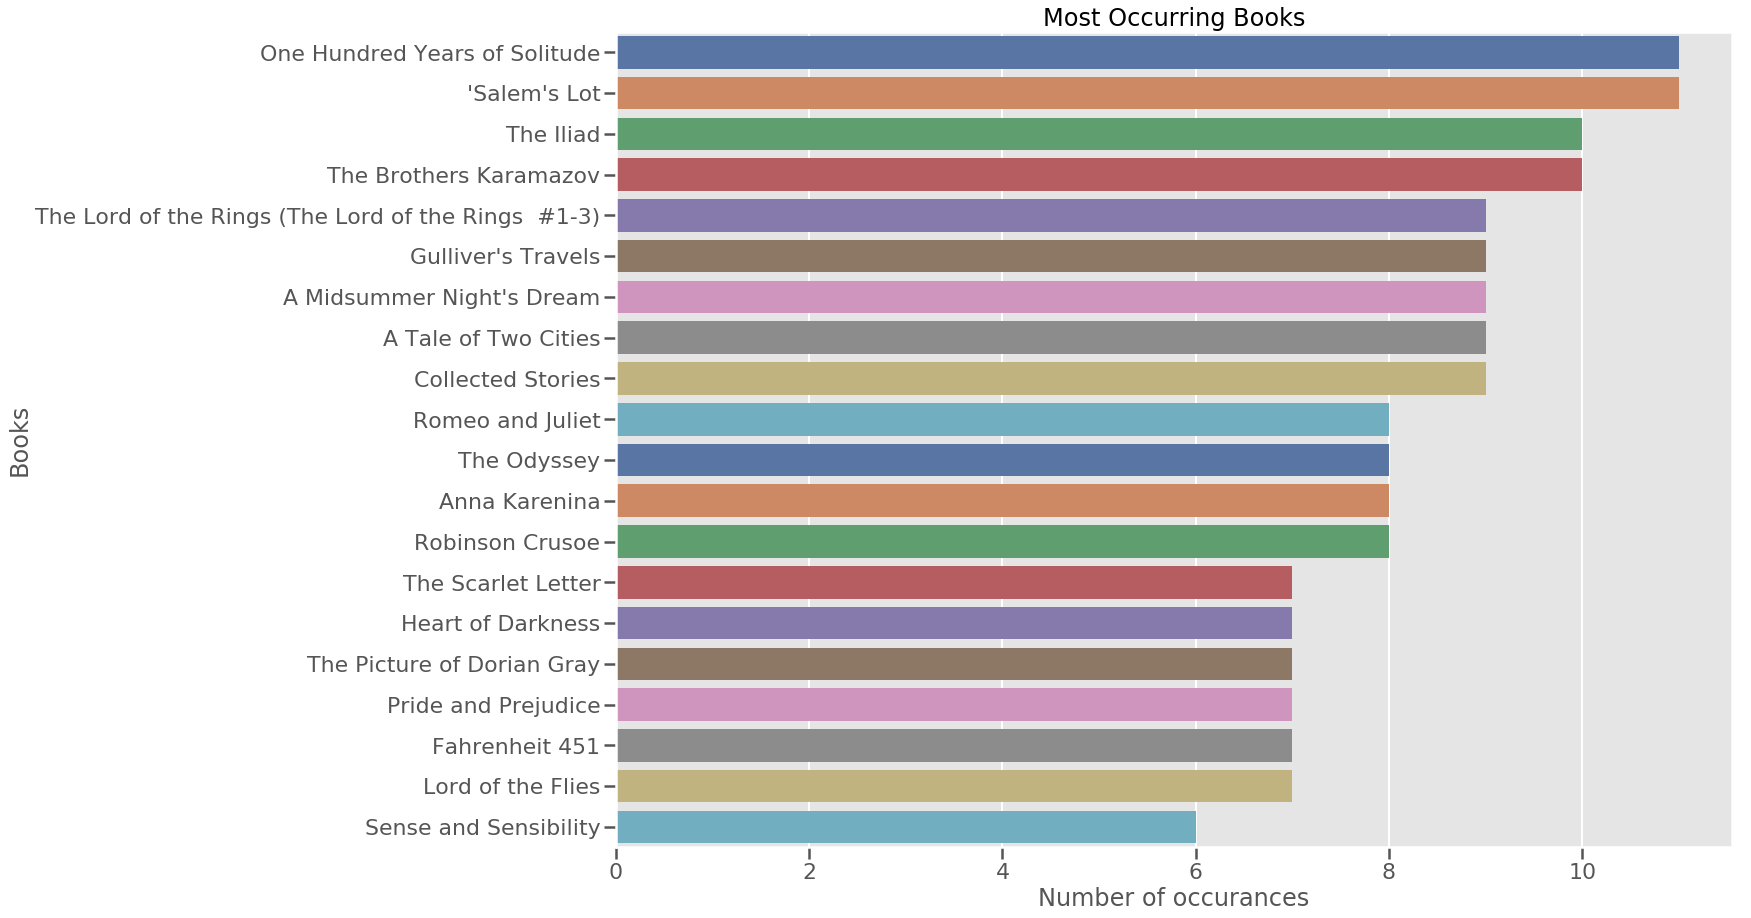

In [10]:
#Taking the first 20:

sns.set_context('poster')
plt.figure(figsize=(20,15))
books = df['title'].value_counts()[:20]
rating = df.average_rating[:20]
sns.barplot(x = books, y = books.index, palette='deep')
plt.title("Most Occurring Books")
plt.xlabel("Number of occurances")
plt.ylabel("Books")
plt.show()

We can see that **One Hundred Years Of Solitude** and **Salem's List** have the most number of occurrances with the same name in the data. 

These books have come up in this database over and over again, with various publication editions. From the list, we can see that most of the books from the given chart are either old, steadfast classics or books which are usually assigned to schools. Seems like some books do age well, and these have just braved the flow of time. 

### What is the distribution of books for all languages?<a id="5"></a> <br>

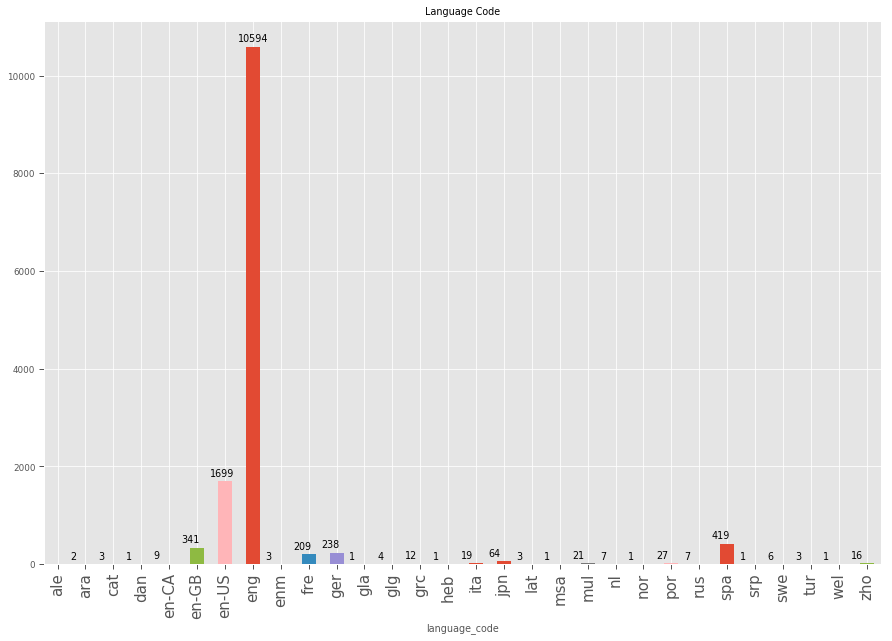

In [11]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

From the given graph, we can infer that in the given data, majority of the books are in english languages, with some further categorised into English-US, english-UK and english-CA.

### Which are the top 10 most rated books?<a id="6"></a> <br>

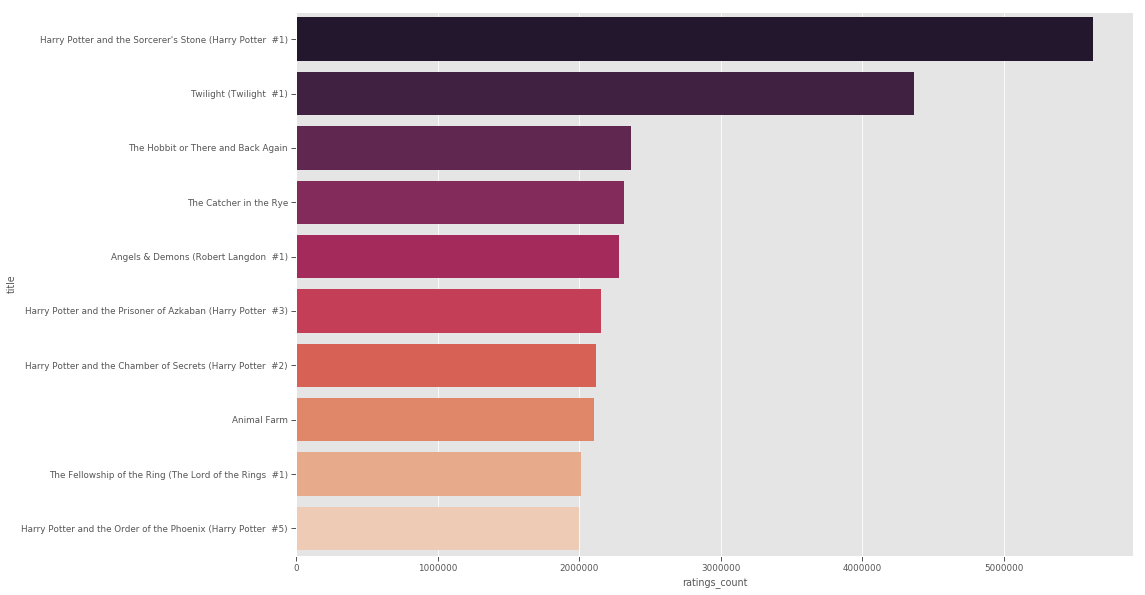

In [12]:
most_rated = df.sort_values('ratings_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.barplot(most_rated['ratings_count'], most_rated.index, palette='rocket')




1 We can see that the beginning books of the series usually have most of the ratings, i.e, **Harry Potter and the Sorcerer's stone**, **Twilight #1**, **The Hobbit**, **Angels and demons #1**.

2 Harry potter's first book dominates the section by having more than 5000000 ratings. Infact, apart from a few, such as Catcher in the Rye and Animal Farm, all of the books seem to be from a series of books, getting the notion into our head that once people begin, most of them seem to dive in with the notion of completing it. 

Yet, when we glance at the first and fifth book of Harry Potter, we can also notice that there has been a ridiculously huge margin in the number of readers/ratings for the books, signifying that there were people who did not pick up the next book in the series and/or only found the first book to touch their hearts up to an extent to drop a vote

### Which are the authors with most books?<a id="7"></a> <br>

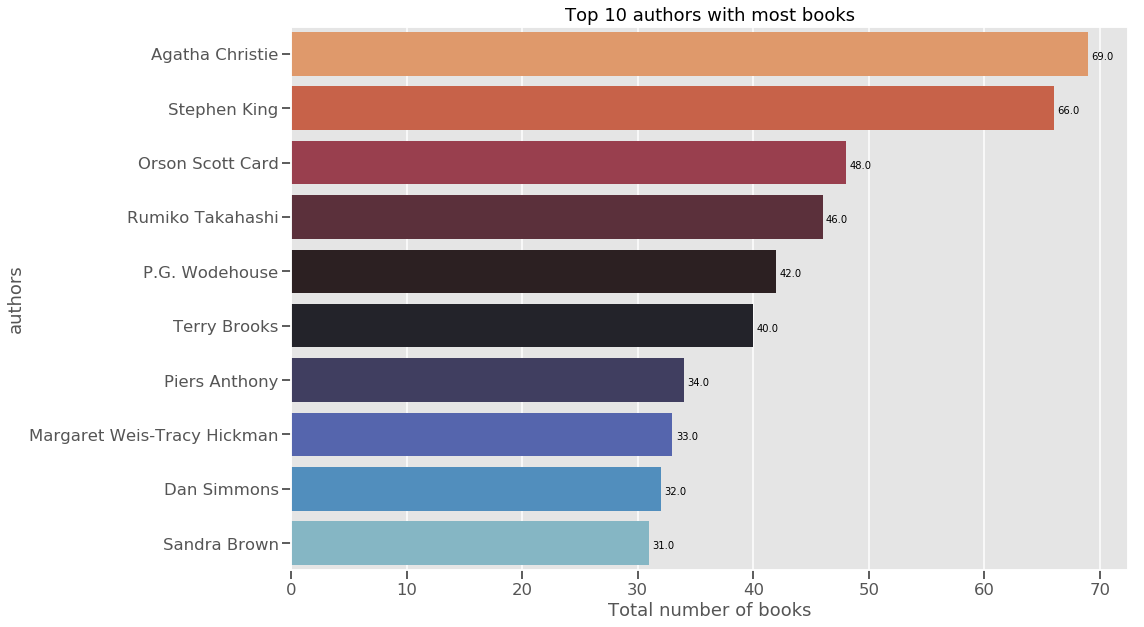

In [13]:
sns.set_context('talk')
most_books = df.groupby('authors')['title'].count().reset_index().sort_values('title', ascending=False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(most_books['title'], most_books.index, palette='icefire_r')
ax.set_title("Top 10 authors with most books")
ax.set_xlabel("Total number of books")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')



We can see from the above plot that Agatha Christie has the most number of books in the list - although a lot of them might be just various publications for the same book, considering the fact that her work has been here for quite a while, spanning decades.

From the names in the list, we can again gather that most of the authors have either been writing for decades, churning numerous books from time to time, or are authors who are regaled as the 'classics' in our history. 

It seems, hype does play a role in this. 

### Getting overall performance for an author over time<a id="8"></a> <br>

In [14]:
client = gr.Client(developer_key= 'fgwnppR6Q1wpFt0n6umUQ') #If possible, please get your own? :)

In [15]:
# Creating a function to get book details from the ISBN 13 value.

#Alternate scraping solution, when both the API(s) fails
def html(isbn):
    url = 'https://isbndb.com/book/'+isbn
    article = Article(url)
    #article = 'https://isbndb.com/book/9780450524684'
    article.download()
    article.parse()
    ar = article.html
    ar = ar[9300:9900]
    return ar

def reg(l):
    return re.search(r'(\b\d{4})\b',l).groups()[0]
    
#Gathering the data for the year column for the books from their ISBN 13 values
def bookdata(df):
    year=[]
    pbar = ProgressBar()
    for isbn in pbar(df.isbn13):
        try:
            details = isbnlib.meta(isbn)
            year.append(details['Year'])
        except :
            #Trying out with goodreads api now
            try: 
                book_detail = client.Book.show_by_isbn(isbn)
                keys_wanted = ['publication_year']
                reduced_book = {k:v for k,v in book_detail.items() if k in keys_wanted}
                year.append((reduced_book['publication_year']))
            
            except: 
                #Going with webscraping
                try:
                    y = html(isbn)
                    year_extracted = reg(y) #Extracting year with regex
                    year.append(y)
                except:
                    year.append('0')
                
    return year

def plot_author_chart(author_df):
    year = bookdata(author_df)
    author_df = final_df(author_df, year)
    author_df.dropna(0, inplace=True)
    author_df = author_df[author_df['Year'].str.isnumeric()]
    author_df = author_df.set_index('title')
    author_df = author_df[author_df.Year !='0']
    plt.figure(figsize=(15,15))
    sns.set_context('talk')
    plt.xticks(rotation=30)
    ax =  sns.barplot( author_df['Year'], author_df['average_rating'], palette='deep')
    ax.set_title("Average rating of books over time, "+ author_df.authors[1])
    plt.xticks(rotation=30)
    return ax



# The finction for getting the final dataframe for the charts
def final_df(df1, l):
    year_df = pd.DataFrame(l, columns=['Year'])
    df1 = df1.reset_index(drop=True)
    final = df1[['authors', 'average_rating', 'title']].join(year_df)
    return final

In [16]:
#Finding the top 15 authors with the most number of books
df['authors'].value_counts().head(10)

Agatha Christie                69
Stephen King                   66
Orson Scott Card               48
Rumiko Takahashi               46
P.G. Wodehouse                 42
Terry Brooks                   40
Piers Anthony                  34
Margaret Weis-Tracy Hickman    33
Dan Simmons                    32
Sandra Brown                   31
Name: authors, dtype: int64

Let's test out the functions now. 
We'll test out the performance of these four authors over time:
- Stephen King
- Agatha Christie
- Dan Brown
- J.K. Rowling

Ranging from authors spanning a few decades with their titles to some of the current favourites, let's see how they fared over time. 

For the sake of brevity, only english language has been used

In [17]:
authors= ['Stephen King', 'Agatha Christie', 'Dan Brown', 'J.K. Rowling']

#### Stephen King: <a id="9"></a> <br> 

100% (58 of 58) |########################| Elapsed Time: 0:00:43 Time:  0:00:43


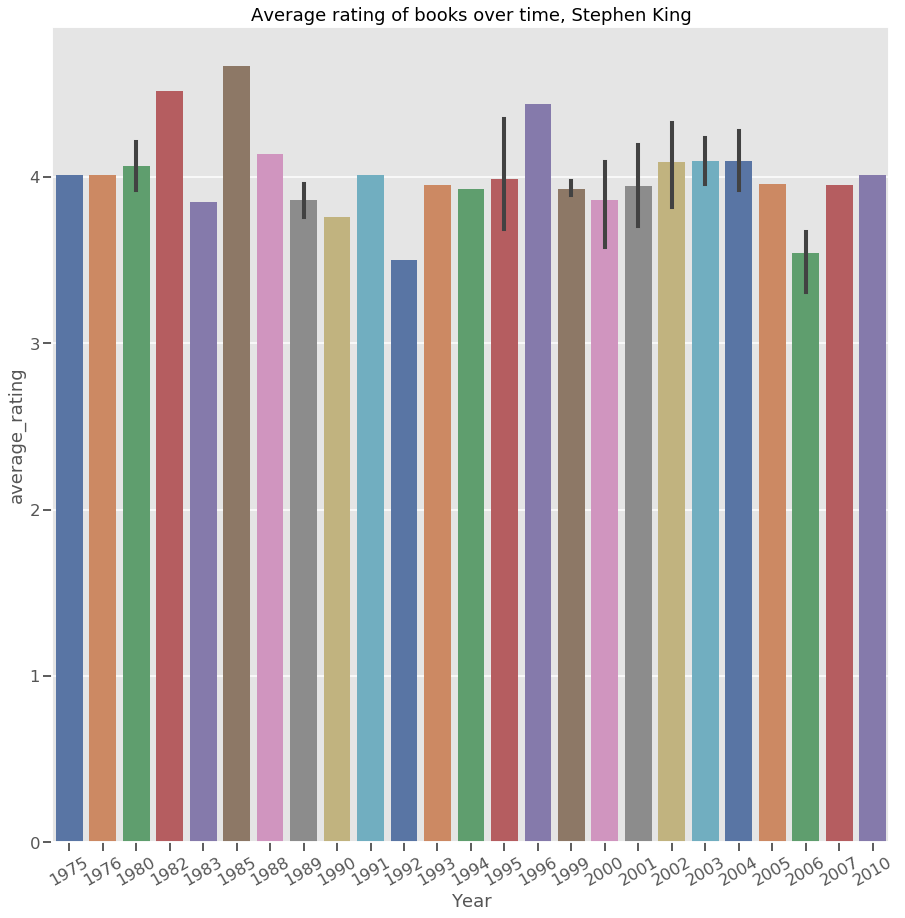

In [18]:
author_df = df[df['authors']==authors[0]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)

We can notice from the plot that Stephen King was at his best in 1987, hitting the peak. His performance has been steadily consitent, dipping once in the nineties and after the new turn of the decade. Known for his famous works such as Rita Hayworth and Shawshank, which coincidently resides within his best range, 1982-1987, Stephen King is a legend in his own rights.

#### Agatha Christie <a id="10"></a> <br>

100% (65 of 65) |########################| Elapsed Time: 0:00:49 Time:  0:00:49


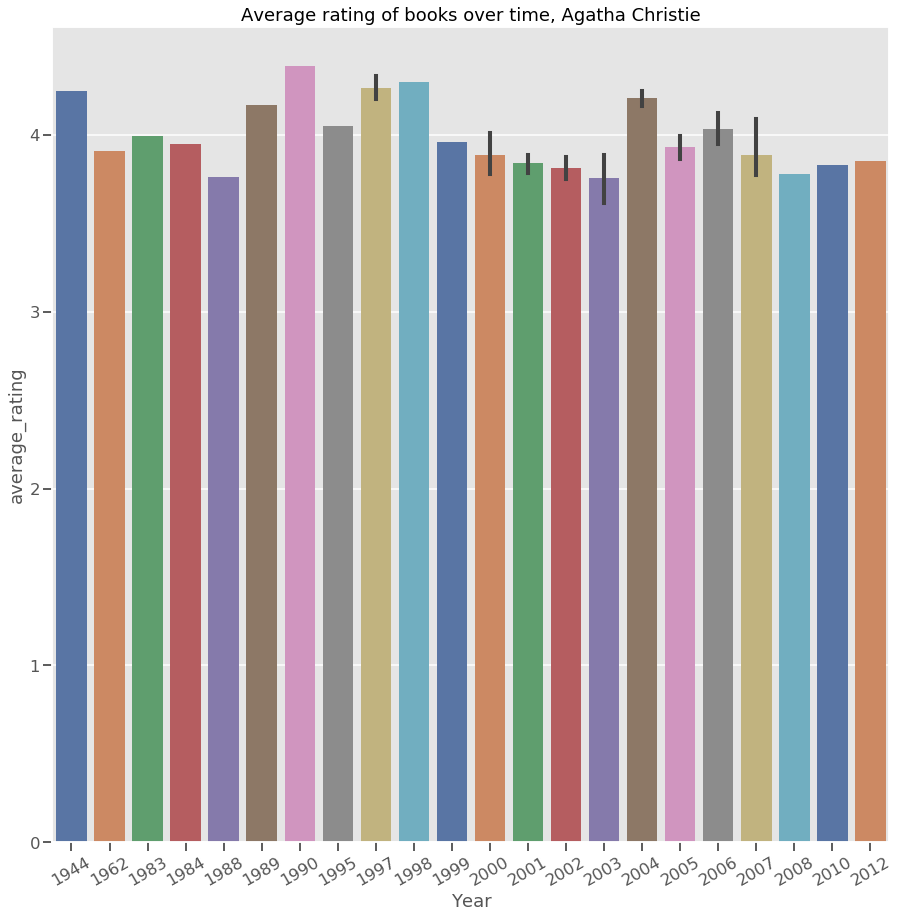

In [19]:
author_df = df[df['authors']==authors[1]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)

Agatha Christie has been a legend throughout the course over the years. Most of her books have performed admirably, still staying well above 4, presumably because of Poirot and his fabulous skills (Might even give Sherlock a run for his money)

From this chart, it's perhaps safe to assume that the performance of her books were perhaps the least volatile

#### Dan Brown <a id="11"></a> <br>

100% (11 of 11) |########################| Elapsed Time: 0:00:07 Time:  0:00:07


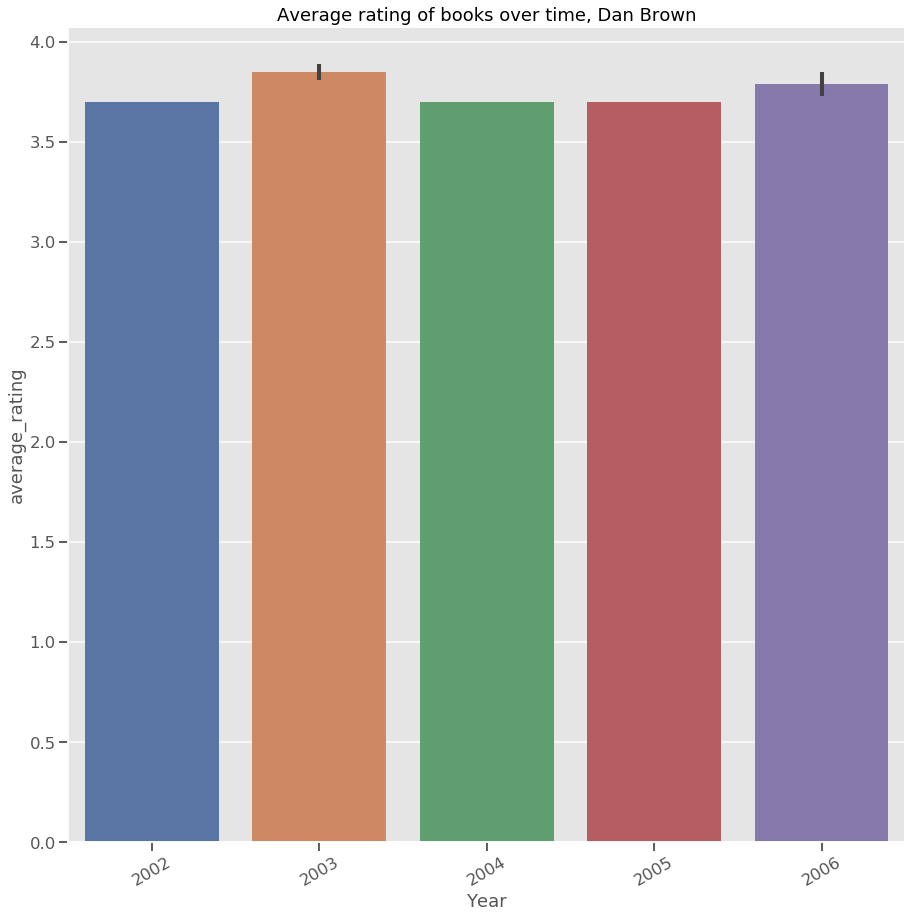

In [20]:
author_df = df[df['authors']==authors[2]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)

Presumably a fan favourite for the current generation, Dan Brown seems to write fabulous thrillers with a knack for them to still retain the potential to be brilliant page-turners. 

Yet, from the data yet obtained, it can be observed that he has the least ratings amongst the four chosen authors, yet, he is consistent. 

#### J.K. Rowling <a id="12"></a> <br>

100% (14 of 14) |########################| Elapsed Time: 0:00:11 Time:  0:00:11


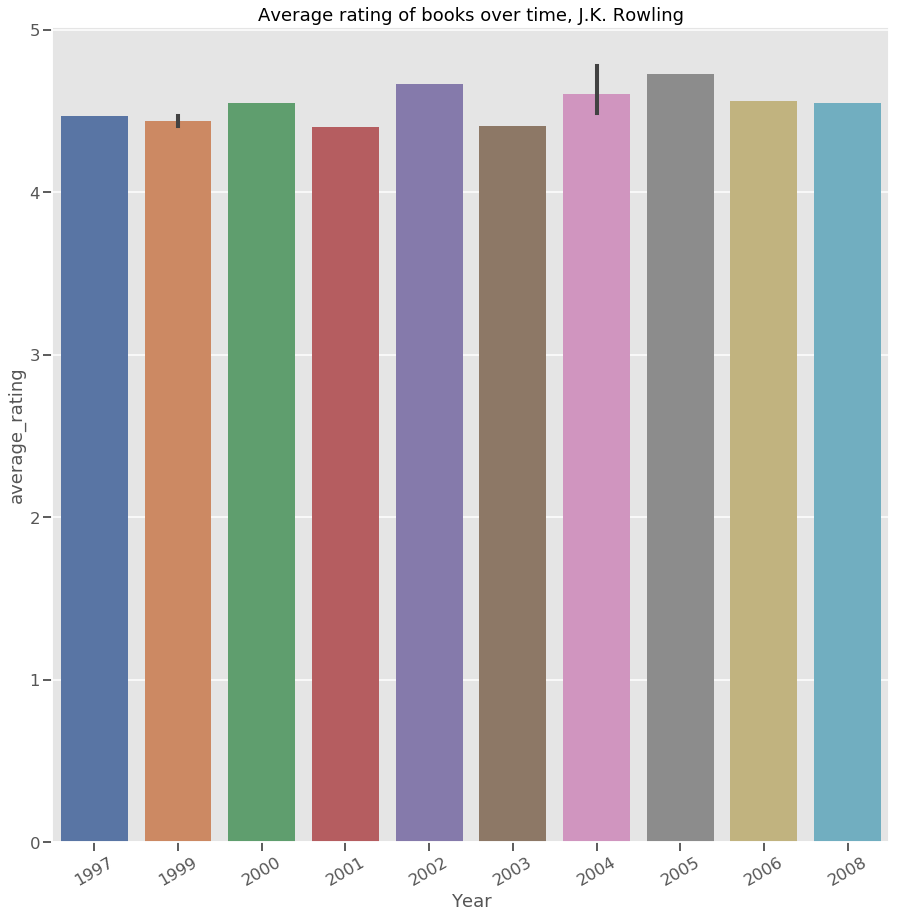

In [21]:
author_df = df[df['authors']==authors[3]]
author_df = author_df[author_df['language_code']=='eng']
plot_author_chart(author_df)




And finally, Harry Potter. The phenomenon for this era, the book which sold the most copies in the world. The series which has steadfastly garnered fans all over the world. 

A boy with a scar, a penchance for heroism. 

And the beauty shines, when observing the plot. All above four, brilliantly defying the rating trends which nearly all seem to follow. 

Perhaps a personal favourite for many of us, yet, we sure were rooting for this!

### Which are the top 10 highly rated authors?<a id="13"></a> <br>

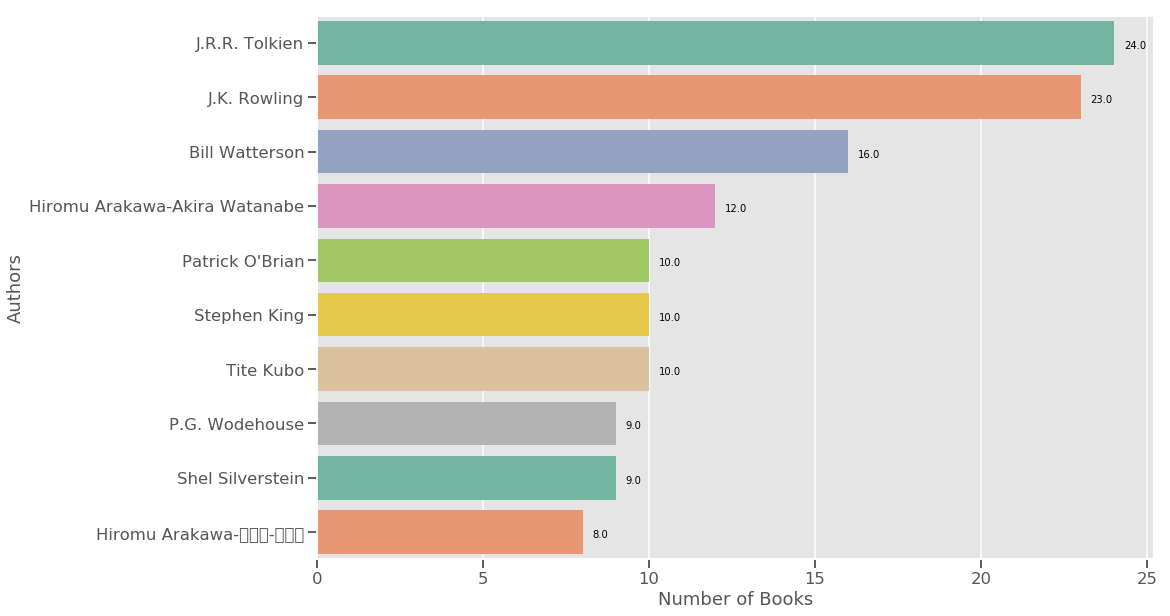

In [22]:
high_rated_author = df[df['average_rating']>=4.3]
high_rated_author = high_rated_author.groupby('authors')['title'].count().reset_index().sort_values('title', ascending = False).head(10).set_index('authors')
plt.figure(figsize=(15,10))
ax = sns.barplot(high_rated_author['title'], high_rated_author.index, palette='Set2')
ax.set_xlabel("Number of Books")
ax.set_ylabel("Authors")
for i in ax.patches:
    ax.text(i.get_width()+.3, i.get_y()+0.5, str(round(i.get_width())), fontsize = 10, color = 'k')





We can infer from the plot that J.R.R tolkien has the highest ratings for his books, making his average consistency rather impressive. 

It's also impressive to note the vast dominance Tolkien has over the competition, easily dethroning any other competiton while being above 4.3 in rating.

### What is the rating distribution for the books?<a id="14"></a> <br>

In [23]:

def segregation(data):
    values = []
    for val in data.average_rating:
        if val>=0 and val<=1:
            values.append("Between 0 and 1")
        elif val>1 and val<=2:
            values.append("Between 1 and 2")
        elif val>2 and val<=3:
            values.append("Between 2 and 3")
        elif val>3 and val<=4:
            values.append("Between 3 and 4")
        elif val>4 and val<=5:
            values.append("Between 4 and 5")
        else:
            values.append("NaN")
    print(len(values))
    return values

In [24]:
df.average_rating.isnull().value_counts()

False    13714
Name: average_rating, dtype: int64

In [25]:
df.dropna(0, inplace=True)
#Removing Any null values

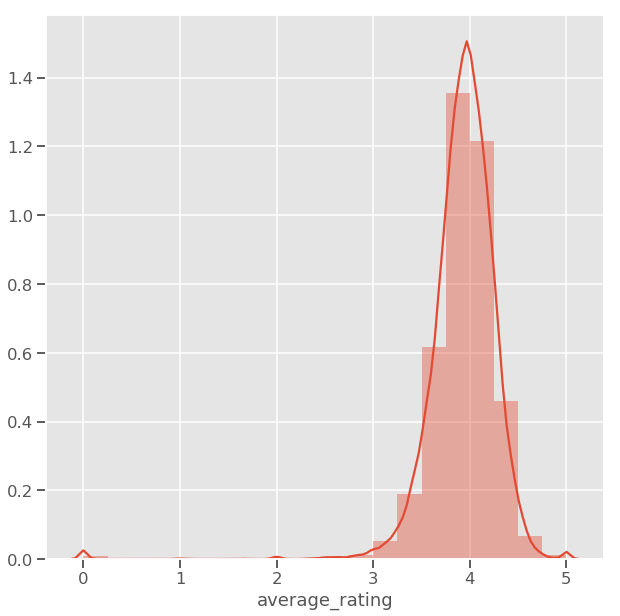

In [26]:
plt.figure(figsize=(10,10))
rating= df.average_rating.astype(float)
sns.distplot(rating, bins=20)



From the given plot, we can infer that: 

- Majority of the ratings lie near 3.7-4.3, approximately.
- Books having scores near 5 are extremely rare

13714


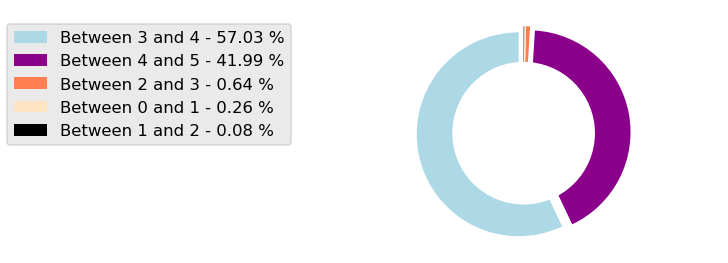

In [27]:
df['Ratings_Dist'] = segregation(df)
ratings_pie = df['Ratings_Dist'].value_counts().reset_index()
labels = ratings_pie['index']
colors = ['lightblue','darkmagenta','coral','bisque', 'black']
percent = 100.*ratings_pie['Ratings_Dist']/ratings_pie['Ratings_Dist'].sum()
fig, ax1 = plt.subplots()
ax1.pie(ratings_pie['Ratings_Dist'],colors = colors, 
        pctdistance=0.85, startangle=90, explode=(0.05, 0.05, 0.05, 0.05, 0.05))
#Draw a circle now:
centre_circle = plt.Circle((0,0), 0.70, fc ='white')
fig1 = plt.gcf()
fig1.gca().add_artist(centre_circle)
#Equal Aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')
plt.tight_layout()
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(labels, percent)]
plt.legend( labels, loc = 'best',bbox_to_anchor=(-0.1, 1.),)



Surprisingly, it can be seen that the ratings between 0 and 1 are much more numerous in number, leading to a conclusion that if a person does read a book and end up hating it, it'll still get a minimum of around 2 stars, just for the effort they put up for reading the book. 

The kurtosis of the graph just seems to land between 3 and 4, signifying that for the effort it took to read, and the thrilling, unputdownable nature of the book, the majority of the ratings lie between 3 and 4.

### Is there any relationship between ratings and review counts?<a id="15"></a> <br>


<Figure size 1080x720 with 0 Axes>

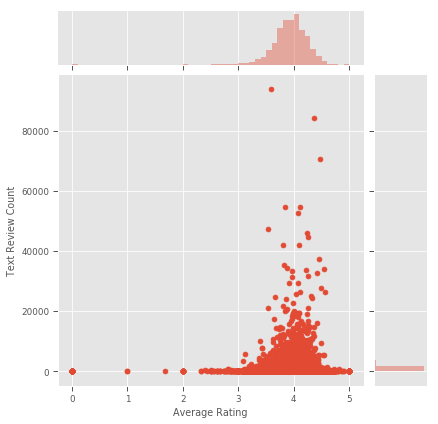

In [28]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= df[['text_reviews_count', 'average_rating']])
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()



Analysis: We can infer from the plot that most of the ratings for the books seems to lie near 3-4, with a heavy amount of reviews lying barely near 5000, approximately. Let's plot that. 

In [29]:
trial = df[~(df['text_reviews_count']>5000)]

<Figure size 1080x720 with 0 Axes>

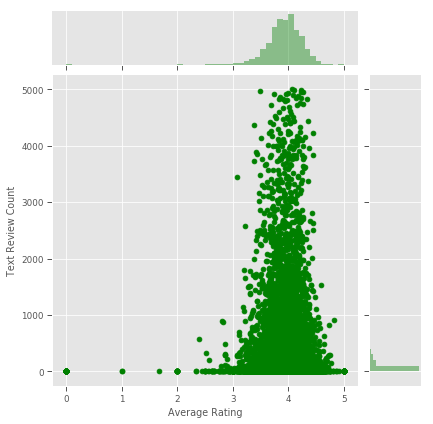

In [30]:
#Checking for any relation between them.
plt.figure(figsize=(15,10))
df.dropna(0, inplace=True)
sns.set_context('paper')
ax =sns.jointplot(x="average_rating",y='text_reviews_count', kind='scatter',  data= trial, color = 'green')
ax.set_axis_labels("Average Rating", "Text Review Count")
plt.show()



It can be observed that even now, the majority of text reviews for books still lie under 1000, making this whole scenario inconclusive. There might be a relationship, but the reviews seem to be predominant amongst books with decent ratings.

Perhaps they are all scam reviews, or the density of the books in that field are just that _more_.

### Is there a relationship between number of pages and ratings?<a id="16"></a> <br>

<Figure size 1080x720 with 0 Axes>

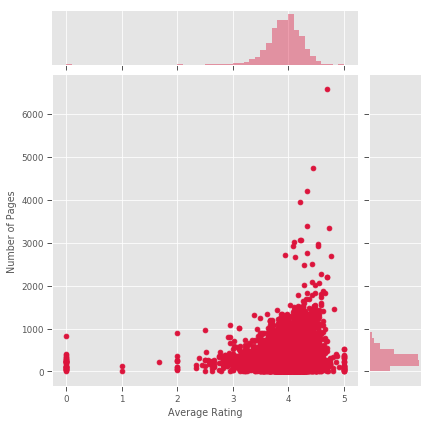

In [31]:
plt.figure(figsize=(15,10))
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="# num_pages", data = df, color = 'crimson')
ax.set_axis_labels("Average Rating", "Number of Pages")


Analysis: This plot doesn't give that much of an accurate inference due to the massive presence of outliers for books above 1000 pages, for the _maximum_ density is between 0-1000 pages. 

Based on that logic, let's explore the scenario in that range: 

In [32]:
trial = df[~(df['# num_pages']>1000)]

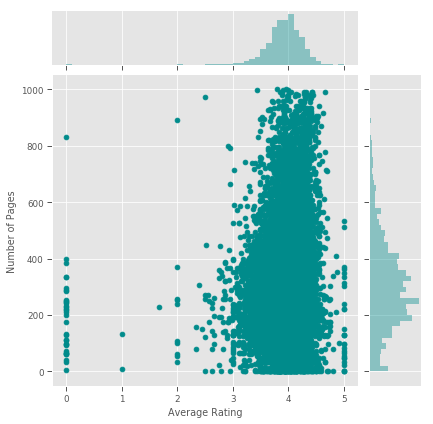

In [33]:
ax = sns.jointplot(x="average_rating", y="# num_pages", data = trial, color = 'darkcyan')
ax.set_axis_labels("Average Rating", "Number of Pages")


Analysis: From the given plot, we can infer that the highest ratings ever given, usually are for books with the page range of **200-400**, peaking near 250. It could lead to the fact that most of the people seem to prefer books with a moderate amount of pages, and that thicker books seems to scare people away. 

## Is there a relationship between ratings and ratings count?<a id="17"></a> <br>

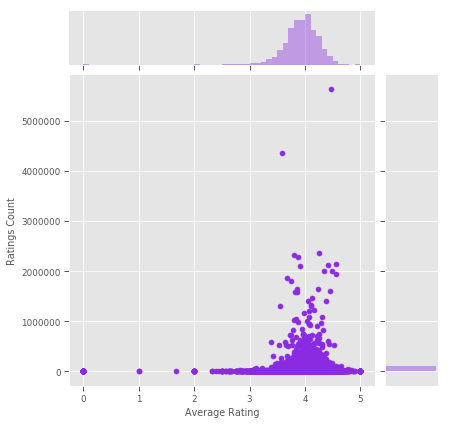

In [34]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = df, color = 'blueviolet')
ax.set_axis_labels("Average Rating", "Ratings Count")


There seem to be some outliers present in this. For a better outlook, let's consider the count around 2000000 ratings

In [35]:
trial = df[~(df.ratings_count>2000000)]

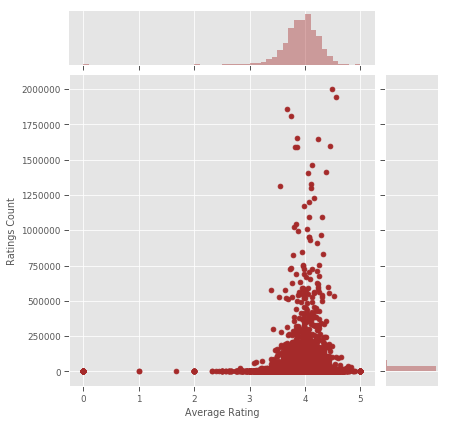

In [36]:
sns.set_context('paper')
ax = sns.jointplot(x="average_rating", y="ratings_count", data = trial, color = 'brown')
ax.set_axis_labels("Average Rating", "Ratings Count")


From the graph, we can see that there can be a potential relationship between the average rating and ratings count. As the number of ratings increase, the rating for the book seems to taper towards 4. The average rating seems to become sparse while the number keeps on decreasing.

### Which are the books with the highest reviews? <a id="18"></a> <br>

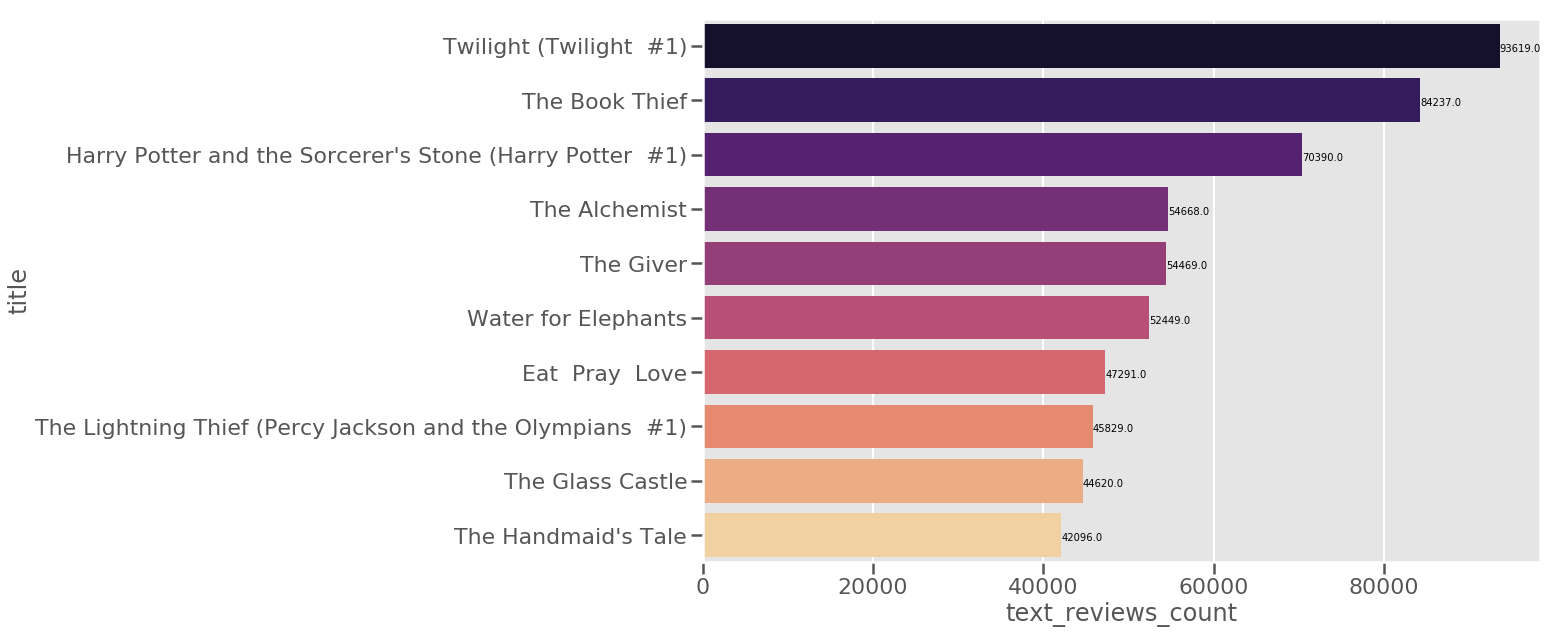

In [37]:
most_text = df.sort_values('text_reviews_count', ascending = False).head(10).set_index('title')
plt.figure(figsize=(15,10))
sns.set_context('poster')
ax = sns.barplot(most_text['text_reviews_count'], most_text.index, palette='magma')
for i in ax.patches:
    ax.text(i.get_width()+2, i.get_y()+0.5,str(round(i.get_width())), fontsize=10,color='black')
plt.show()




From all the above inferences, we can fundamentally decide that although the reviews matter, there can't be any specific relation between them and the ranking for all the books

# Topic Modelling <a id="19"></a> <br>

### KMeans Clustering without outliers <a id="20"></a> <br>

![](http://shabal.in/visuals/kmeans/random.gif)

KMeans clustering is a type of unsupervised learning which groups unlabelled data. The goal is to find groups in data. 

With this, I attepmt to find a relationship or groups between the rating count and average rating value. 

In [38]:
trial = df[['average_rating', 'ratings_count']]
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T



I'll use the Elbow Curve method for the best way of finding the number of clusters for the data

Text(0.5, 1.0, 'Elbow Curve')

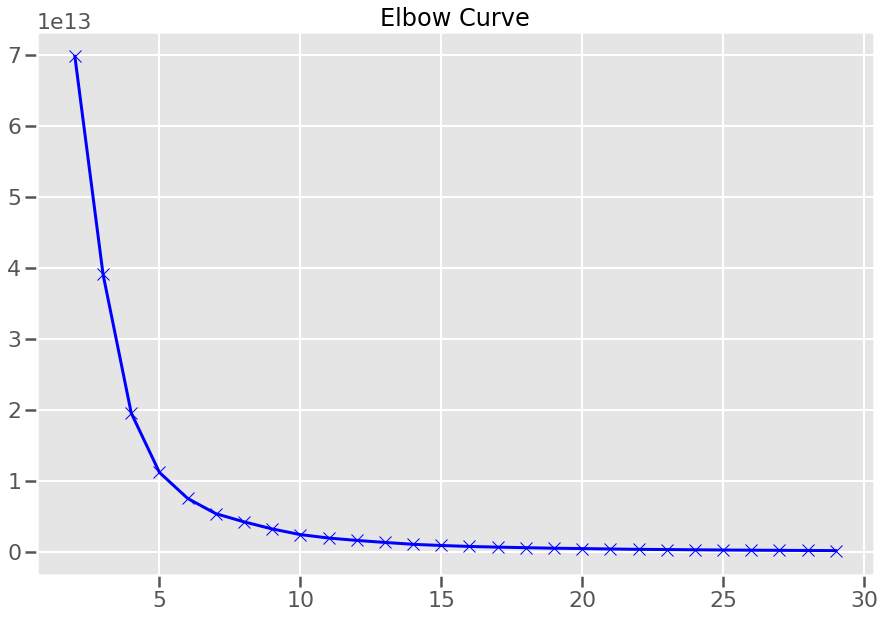

In [39]:
X = data
distortions = []
for k in range(2,30):
    k_means = KMeans(n_clusters = k)
    k_means.fit(X)
    distortions.append(k_means.inertia_)

fig = plt.figure(figsize=(15,10))
plt.plot(range(2,30), distortions, 'bx-')
plt.title("Elbow Curve")

From the above plot, we can see that the elbow lies around the value K=5, so that's what we will attempt it with

In [40]:
#Computing K means with K = 5, thus, taking it as 5 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

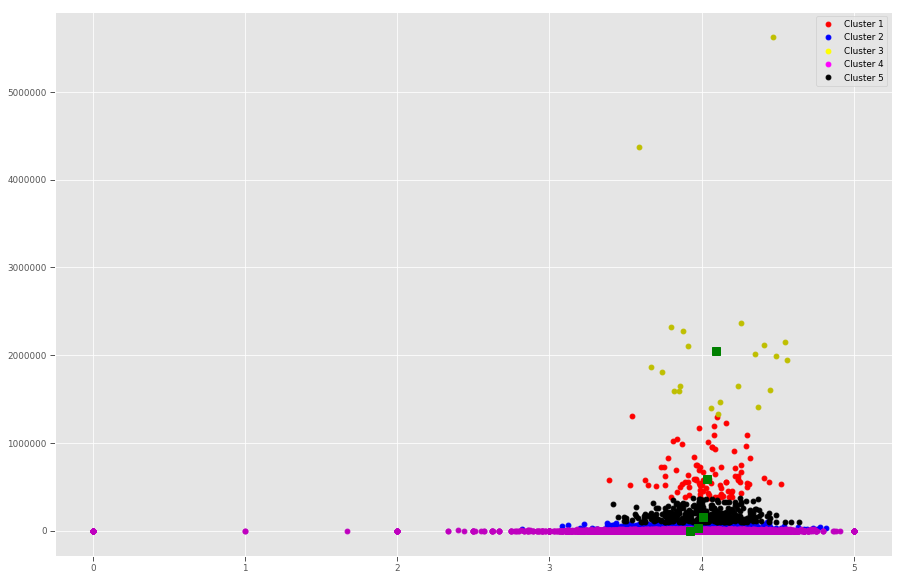

In [41]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    
     
        
        
        
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

We can see from the above plot, that because of two outliers, the whole clustering algortihm is skewed. Let's remove them and form inferences

## KMeans with optimisation <a id="21"></a> <br>

Finding the outliers and then removing them.

In [42]:
trial.idxmax()

average_rating    2034
ratings_count        3
dtype: int64

In [43]:
trial.drop(3, inplace = True)
trial.drop(41865, inplace = True)

In [44]:
data = np.asarray([np.asarray(trial['average_rating']), np.asarray(trial['ratings_count'])]).T




In [45]:
#Computing K means with K = 8, thus, taking it as 8 clusters
centroids, _ = kmeans(data, 5)

#assigning each sample to a cluster
#Vector Quantisation:

idx, _ = vq(data, centroids)

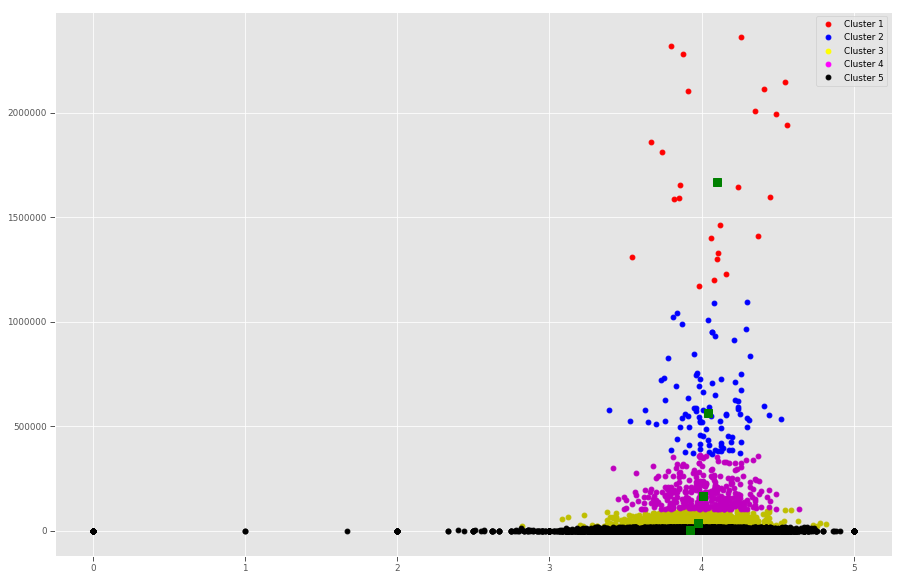

In [46]:
# some plotting using numpy's logical indexing
sns.set_context('paper')
plt.figure(figsize=(15,10))
plt.plot(data[idx==0,0],data[idx==0,1],'or',#red circles
     data[idx==1,0],data[idx==1,1],'ob',#blue circles
     data[idx==2,0],data[idx==2,1],'oy', #yellow circles
     data[idx==3,0],data[idx==3,1],'om', #magenta circles
     data[idx==4,0],data[idx==4,1],'ok',#black circles
    
     
        
        
        
        
        )
plt.plot(centroids[:,0],centroids[:,1],'sg',markersize=8, )




circle1 = Line2D(range(1), range(1), color = 'red', linewidth = 0, marker= 'o', markerfacecolor='red')
circle2 = Line2D(range(1), range(1), color = 'blue', linewidth = 0,marker= 'o', markerfacecolor='blue')
circle3 = Line2D(range(1), range(1), color = 'yellow',linewidth=0,  marker= 'o', markerfacecolor='yellow')
circle4 = Line2D(range(1), range(1), color = 'magenta', linewidth=0,marker= 'o', markerfacecolor='magenta')
circle5 = Line2D(range(1), range(1), color = 'black', linewidth = 0,marker= 'o', markerfacecolor='black')

plt.legend((circle1, circle2, circle3, circle4, circle5)
           , ('Cluster 1','Cluster 2', 'Cluster 3', 'Cluster 4', 'Cluster 5'), numpoints = 1, loc = 0, )


plt.show()

From the above plot, now we can see that once the whole system _can_ be classified into clusters. As the count increases, the rating would end up near the cluster given above. The green squares are the centroids for the given clusters. 

As the rating count seems to decrease, the average rating seems to become sparser, with higher volatility and less accuracy. 

## Recommendation Engine <a id="22"></a> <br>


Having seen the clustering, we can infer that there can be some recommendations which can happen with the relation between Average Rating and Ratings Count. 

Taking the Ratings_Distribution (A self created classifying trend), the recommendation system works with the algortihm of K Nearest Neighbors. 

Based on a book entered by the user, the nearest neighbours to it would be classified as the books which the user might like. 

KNN is used for both classification and regression problems. In classification problems to predict the label of a instance we first find k closest instances to the given one based on the distance metric and based on the majority voting scheme or weighted majority voting(neighbors which are closer are weighted higher) we predict the labels.

![](https://miro.medium.com/max/1400/1*j95msWf8y2B_cbQVMzxFWg.png)

In a setting such as this, the unsupervised learning takes place, with the similar neighbors being recommended. For the given list, if I ask recommendations for "The Catcher in the Rye", five books related to it would appear. 

Creating a books features table, based on the Ratings Distribution, which classifies the books into ratings scale such as: 
- Between 0 and 1
- Between 1 and 2
- Between 2 and 3
- Between 3 and 4
- Between 4 and 5

Broadly, the recommendations then consider the average ratings and ratings cout for the query entered.

In [47]:
books_features = pd.concat([df['Ratings_Dist'].str.get_dummies(sep=","), df['average_rating'], df['ratings_count']], axis=1)

In [48]:
books_features.head()

,Between 0 and 1,Between 1 and 2,Between 2 and 3,Between 3 and 4,Between 4 and 5,average_rating,ratings_count
bookID,,,,,,,
1,0,0,0,0,1,4.56,1944099
2,0,0,0,0,1,4.49,1996446
3,0,0,0,0,1,4.47,5629932
4,0,0,0,0,1,4.41,6267
5,0,0,0,0,1,4.55,2149872


The min-max scaler is used to reduce the bias which would have been present due to some books having a massive amount of features, yet the rest having less. Min-Max scaler would find the median for them all and equalize it. 


In [49]:
min_max_scaler = MinMaxScaler()
books_features = min_max_scaler.fit_transform(books_features)

In [50]:
np.round(books_features, 2)

array([[0.  , 0.  , 0.  , ..., 1.  , 0.91, 0.35],
       [0.  , 0.  , 0.  , ..., 1.  , 0.9 , 0.35],
       [0.  , 0.  , 0.  , ..., 1.  , 0.89, 1.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.71, 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.89, 0.  ],
       [0.  , 0.  , 0.  , ..., 1.  , 0.86, 0.  ]])

In [51]:
model = neighbors.NearestNeighbors(n_neighbors=6, algorithm='ball_tree')
model.fit(books_features)
distance, indices = model.kneighbors(books_features)



Creating specific functions to help in finding the book names: 
- Get index from Title
- Get ID from partial name (Because not everyone can remember all the names) 
- Print the similar books from the feature dataset. 
 *(This uses the Indices metric from the nearest neighbors to pick the books.)*

In [52]:
def get_index_from_name(name):
    return df[df["title"]==name].index.tolist()[0]

all_books_names = list(df.title.values)

def get_id_from_partial_name(partial):
    for name in all_books_names:
        if partial in name:
            print(name,all_books_names.index(name))
            
def print_similar_books(query=None,id=None):
    if id:
        for id in indices[id][1:]:
            print(df.iloc[id]["title"])
    if query:
        found_id = get_index_from_name(query)
        for id in indices[found_id][1:]:
            print(df.iloc[id]["title"])

Checking out the Workings of the System, let's try with following examples. 

- System by name: The Catcher in the Rye
- System by Name: The Hobbit
- System by partial name: Harry Potter (Book 5)


#### The Catcher in the Rye:

In [53]:
print_similar_books("The Catcher in the Rye")


Gulliver's Travels
A Lie and a Libel: The History of the Protocols of the Elders of Zion
The Three Musketeers
Gulliver's Travels
Whiteout


#### The Hobbit or There and Back Again:

In [54]:
print_similar_books("The Hobbit or There and Back Again")

Home of the Gentry
Air Gear  Vol. 1 (Air Gear  #1)
Falling Angel
The Place of Dead Roads
Thomas Jefferson: Author of America


#### Harry Potter Book 5:

Since most users won't remember the name for the entire book (Especially how it has been entered in the books database), the function to get ID from the partial names helps to choose to ID of the book the user is looking for. 

In [55]:
get_id_from_partial_name("Harry Potter and the ")

Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Order of the Phoenix (Harry Potter  #5) 1
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 2
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 3
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 4
Harry Potter and the Half-Blood Prince (Harry Potter  #6) 0
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3) 4
Harry Potter and the Chamber of Secrets (Harry Potter  #2) 3
Harry Potter and the Sorcerer's Stone (Harry Potter  #1) 2
Harry Potter and the Philosopher's Stone (Harry Potter  #1) 12660
Harry Potter and the Goblet of Fire (Harry Potter  #4) 12663


In [56]:
print_similar_books(id = 1) #ID for the Book 5

Harry Potter and the Half-Blood Prince (Harry Potter  #6)
Harry Potter and the Chamber of Secrets (Harry Potter  #2)
The Fellowship of the Ring (The Lord of the Rings  #1)
Harry Potter and the Prisoner of Azkaban (Harry Potter  #3)
A Game of Thrones (A Song of Ice and Fire  #1)


## -x-

**If you liked the kernel, do consider upvoting it! :)**